In [1]:
import geopandas as gpd
collisions = gpd.read_file('nyc-collision-factors.geojson')

In [23]:
nmin = 1
gdf = collisions

In [31]:
from shapely.geometry import Polygon

In [37]:
from shapely.ops import cascaded_union

In [44]:
list(cascaded_union(
    [
        square(1,1,2,2),
        square(1,2,2,3)
    ]
).exterior.coords)

[(2.0, 2.0),
 (2.0, 1.0),
 (1.0, 1.0),
 (1.0, 2.0),
 (1.0, 3.0),
 (2.0, 3.0),
 (2.0, 2.0)]

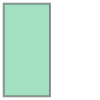

In [46]:
cascaded_union(
    [
        square(1,1,2,2),
        square(1,2,2,3)
    ]
)

In [67]:
from shapely.geometry import LineString

Initial implementation, just testing for correctness.

In [115]:
def square(minx, maxx, miny, maxy):
    return Polygon(
        [[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy]]
    )

def consolidate(tups):
    tot = sum([c[1] for c in tups])
    shp = cascaded_union([c[0] for c in tups])
    return [(shp, tot)]

def split(gdf, nmin):
    if len(gdf) <= 1:
        return [], []
    
    min_x, min_y, max_x, max_y = gdf.total_bounds
    if len(gdf) < nmin:
        return [], [(min_x, max_x, min_y, max_y, len(gdf))]
    
    mid_x, mid_y = (min_x + max_x) / 2, (min_y + max_y) / 2
    lx = gdf.geometry.x < mid_x
    rx = ~lx
    dy = gdf.geometry.y < mid_y
    uy = ~dy
    q1 = gdf[rx & uy]
    q2 = gdf[lx & uy]
    q3 = gdf[lx & dy]
    q4 = gdf[rx & dy]

    todo, complete = [], []
    if len(q1) < nmin:
        print('Q1')
        complete.append((square(mid_x, max_x, mid_y, max_y), len(q1)))
    else:
        todo.append(q1)
    if len(q2) < nmin:
        print('Q2')
        print(min_x, mid_x, mid_y, max_y)
        complete.append((square(min_x, mid_x, mid_y, max_y), len(q2)))
    else:
        todo.append(q2)
    if len(q3) < nmin:
        print('Q3')
        complete.append((square(min_x, mid_x, min_y, mid_y), len(q3)))
    else:
        todo.append(q3)
    if len(q4) < nmin:
        print('Q4')
        print(mid_x, max_x, min_y, mid_y)
        complete.append((square(mid_x, max_x, min_y, mid_y), len(q4)))
    else:
        todo.append(q4)
    
    if len(complete) == 3:
        complete = consolidate(complete)
    elif len(complete) == 2:
        if type(complete[0][0].intersection(complete[1][0])) is LineString:
            complete = consolidate(complete)

    return todo, complete

In [116]:
todo, complete = split(collisions, 1)

In [117]:
from shapely.geometry import Point

In [118]:
todo, complete = split(gpd.GeoDataFrame(geometry=[Point(0, 0), Point(1, 1)]), 1)

Q2
0.0 0.5 0.5 1.0
Q4
0.5 1.0 0.0 0.5


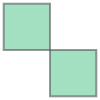

In [119]:
cascaded_union([complete[0][0], complete[1][0]])

In [120]:
todo, complete = split(gpd.GeoDataFrame(geometry=[Point(0, 0), Point(0, 1), Point(1, 1)]), 1)

Q4
0.5 1.0 0.0 0.5


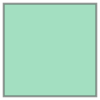

In [121]:
complete[0][0]

In [122]:
todo, complete = split(gpd.GeoDataFrame(geometry=[Point(0, 0)]), 1)

In [126]:
todo, complete

([], [])

In [128]:
todo, complete = split(gpd.GeoDataFrame(
    geometry=[Point(0, 0), Point(0.25, 0.25), Point(0.75, 0.75), Point(0.75, 0.25)]
), 2)

Q1
Q2
0.0 0.375 0.375 0.75
Q4
0.375 0.75 0.0 0.375


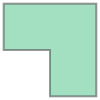

In [130]:
complete[0][0]

OK, now let's write out to and take from a queue.

In [131]:
from multiprocessing import Queue

In [137]:
def square(minx, maxx, miny, maxy):
    return Polygon(
        [[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy]]
    )

def consolidate(tups):
    tot = sum([c[1] for c in tups])
    shp = cascaded_union([c[0] for c in tups])
    return [(shp, tot)]

def split(gdf, nmin):
    if len(gdf) <= 1:
        return [], []
    
    min_x, min_y, max_x, max_y = gdf.total_bounds
    if len(gdf) < nmin:
        return [], [(min_x, max_x, min_y, max_y, len(gdf))]
    
    mid_x, mid_y = (min_x + max_x) / 2, (min_y + max_y) / 2
    lx = gdf.geometry.x < mid_x
    rx = ~lx
    dy = gdf.geometry.y < mid_y
    uy = ~dy
    q1 = gdf[rx & uy]
    q2 = gdf[lx & uy]
    q3 = gdf[lx & dy]
    q4 = gdf[rx & dy]

    todo, complete = [], []
    if len(q1) < nmin:
        print('Q1')
        complete.append((square(mid_x, max_x, mid_y, max_y), len(q1)))
    else:
        todo.append(q1)
    if len(q2) < nmin:
        print('Q2')
        print(min_x, mid_x, mid_y, max_y)
        complete.append((square(min_x, mid_x, mid_y, max_y), len(q2)))
    else:
        todo.append(q2)
    if len(q3) < nmin:
        print('Q3')
        complete.append((square(min_x, mid_x, min_y, mid_y), len(q3)))
    else:
        todo.append(q3)
    if len(q4) < nmin:
        print('Q4')
        print(mid_x, max_x, min_y, mid_y)
        complete.append((square(mid_x, max_x, min_y, mid_y), len(q4)))
    else:
        todo.append(q4)
    
    if len(complete) == 3:
        complete = consolidate(complete)
    elif len(complete) == 2:
        if type(complete[0][0].intersection(complete[1][0])) is LineString:
            complete = consolidate(complete)

    return todo, complete


def worker():
    while True:
        try:
            task = q.get(timeout=1)
            
            # do some work
            pass
            
            q.task_done()
        except Empty:  # queue.Empty
            if e.is_set():
                return
        

def main():
    e = multiprocessing.Event()
    q = JoinableQueue()
    
    p = Process(target=worker, args=(q.get(),))
    p.start()

    q.join()
    e.set()
    p.join()
    print('Done!')

Here we discover a problem with the implementation of `multiprocessing.Queue` that's not immediately obvious from our reading. The queue adds objects to the queue using a worker thread separate from the main thread of the process. Even though the documentation claims that the `put` operation blocks on the main thread, but this is bullshit. The main thread continues to run and to execute code before the put thread has a chance to run.

This means that we can add a job to the queue and then call our main function and immediately exit because there is nothing in the queue yet. The queue gets garbage collected, *then* the putter thread runs, resulting in a *very* irritating broken pipe error.

There is a `join_thread` method available which causes the main thread to wait until all of the put operations are done. However, `join` can *only* be run after `close` is run. `close` locks the queue, e.g. it becomes impossible to `put` any further items on it.

The implication: a multiprocessing program using a `Queue` must use it in a two-phase manner. In the first phase, you construct the queue and lock it. In the second phase you run the actual tasks. This is not what we need for `quadtree`; this algorithm requires dynamically adding tasks to the queue as a result of operations on the current task (e.g. this algorithm is implicitly recursive).

The API has a `JoinableQueue` object as well, which may do what we want? This is a `Queue` with two additional methods defined: `join` and `task_done`. `task_done` decrements an internal counter that is incremented by each `put` operation; `join` blocks until this counter is at zero, e.g. the queue is empty. This appears to be a safe alternative to `empty`; `empty` is a best-guess. This doesn't solve our problem.

In [171]:
import multiprocessing as mp
from queue import Empty

e = mp.Event()
q = mp.JoinableQueue()

def worker():
    while True:
        try:
            task = q.get(timeout=1)

            # do some work
            print(task)
            
            q.task_done()
        except Empty:  # queue.Empty
            if e.is_set():
                return
        

def main():
    q.put('foo')

    p = mp.Process(target=worker)
    p.start()

    q.join()
    e.set()
    p.join()
    print('Done!')

main()

foo
Done!


There are two ways to get the effect we want.

This is one of them. Have the worker wait for a task to come up with a timeout. At timeout intervals, poll an `Event` semaphore to check whether or not work has completed. If it hasn't, go back to waiting. If it has, finish up and exit out.

In [172]:
import multiprocessing as mp
from queue import Empty

e = mp.Event()
q = mp.JoinableQueue()

def worker():
    while True:
        task = q.get()

        # do some work
        if task == 'DONE':
            q.task_done()
            return
        else:
            print(task)
            q.task_done()
        

def main():
    q.put('foo')
    q.put('bar')
    q.put('DONE')

    p = mp.Process(target=worker)
    p.start()

    q.join()
    e.set()
    p.join()
    print('Done!')

main()

foo
bar
Done!


The alternative way is to push a sentinel value into the queue. Upon hitting this sentinel value the task exits. This is more efficient than the polling strategy.

In [174]:
import multiprocessing as mp
from queue import Empty

q = mp.JoinableQueue()

def worker():
    while True:
        task = q.get()

        # do some work
        if task == 'DONE':
            q.task_done()
            return
        else:
            print(task)
            q.task_done()
        

def main():
    q.put('foo')
    q.put('bar')

    p1 = mp.Process(target=worker)
    p2 = mp.Process(target=worker)    
    p1.start()
    p2.start()

    q.join()
    q.put('DONE')
    q.put('DONE')
    p1.join()
    p2.join()
    print('Done!')

main()

foo
bar
Done!


With two processes we flag twice.

In [175]:
import random

In [180]:
import multiprocessing as mp
from queue import Empty
import random

q = mp.JoinableQueue()
# p1_done = mp.Event()
# p2_done = mp.Event()

def worker():
    while True:
        task = q.get()

        # do some work
        if task == 'DONE':
            q.task_done()
            return
        else:
            print(task)
            q.task_done()
            if random.random() > 0.5:
                # does this actually block? docs say yes...
                q.put('another_rand_task')


def main():
    q.put('foo')
    q.put('bar')

    p1 = mp.Process(target=worker)
    p2 = mp.Process(target=worker)    
    p1.start()
    p2.start()

    q.join()
    q.put('DONE')
    q.put('DONE')
    p1.join()
    p2.join()
    print('Done!')

main()

foo
bar
another_rand_task
another_rand_task
another_rand_task
another_rand_task
Done!


Here we see how to manage the queue dynamically using this code structure. This works, assuming `q.put` actually blocks. The documentation *says* it does, so.

Anyway, this is still not quite the architecture we want, because a process may still add tasks to the queue after the queue has been emptied.

The task is truly complete IFF every other task is also in a blocked waiting state. If even one task is still processing, that task may refill the queue from empty.

The only way to keep the workers alive in this case and still support shutdown at task completion is to have the tasks wait until they are *all* blocked. Perhaps something clever can be done here with a `Barrier` object.

However, I think this is all unnecessary.

In [ ]:
import multiprocessing as mp
from queue import Empty
import random

q = mp.JoinableQueue()
b = mp.Barrier(3)
# p1_done = mp.Event()
# p2_done = mp.Event()

def worker(barrier):
    while True:
        task = q.get()
        # do some work
        if task == 'DONE':
            q.task_done()
            return
        else:
            print(task)
            q.task_done()
            if random.random() > 0.5:
                # does this actually block? docs say yes...
                q.put('another_rand_task')


def main():
    q.put('foo')
    q.put('bar')

    p1 = mp.Process(target=worker, args=(b,))
    p2 = mp.Process(target=worker, args=(b,))
    p1.start()
    p2.start()

    q.join()
    q.put('DONE')
    q.put('DONE')
    p1.join()
    p2.join()
    print('Done!')

main()